# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

# Data Collection, Preprocessing and Cleansing

## Reading in data

### Climbing down

In [2]:
path = "Climbing_down_stairs/CL"
Climbing_down = []
for i in range(1, 51):
    df = pd.read_csv(path +f"{i}" + "/Accelerometer.csv" )
    df = df.rename(columns={ df.columns[2]: "ACCELEROMETER Z (m/s²)" ,df.columns[3]: "ACCELEROMETER Y (m/s²)", 
                            df.columns[4]: "ACCELEROMETER X (m/s²)"   })
    df = df[['seconds_elapsed', 'ACCELEROMETER X (m/s²)',
   'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)']]
    df1 = pd.read_csv(path +f"{i}" + "/Gyroscope.csv" )
    df1 = df1.rename(columns={ df1.columns[2]: "GYROSCOPE Z (rad/s)" ,df1.columns[3]: "GYROSCOPE Y (rad/s)", 
                            df1.columns[4]: "GYROSCOPE X (rad/s)"   })
    df1 = df1[['time', 'seconds_elapsed', 'GYROSCOPE X (rad/s)',
   'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)']]
    df1.drop(['time', 'seconds_elapsed'], axis=1, inplace=True)
    Climbing = pd.concat([df, df1], axis = 1).values.tolist()
    Climbing_down.append(Climbing)

### Standing up

In [3]:
path = "standing_up/Stand"
Standing = []
for i in range(1, 51):
    df = pd.read_csv(path +f"{i}" + "/Accelerometer.csv" )
    df = df.rename(columns={ df.columns[2]: "ACCELEROMETER Z (m/s²)" ,df.columns[3]: "ACCELEROMETER Y (m/s²)", 
                            df.columns[4]: "ACCELEROMETER X (m/s²)"   })
    df = df[['seconds_elapsed', 'ACCELEROMETER X (m/s²)',
   'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)']]
    df1 = pd.read_csv(path +f"{i}" + "/Gyroscope.csv" )
    df1 = df1.rename(columns={ df1.columns[2]: "GYROSCOPE Z (rad/s)" ,df1.columns[3]: "GYROSCOPE Y (rad/s)", 
                            df1.columns[4]: "GYROSCOPE X (rad/s)"   })
    df1 = df1[['time', 'seconds_elapsed', 'GYROSCOPE X (rad/s)',
   'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)']]

    df1.drop(['time', 'seconds_elapsed'], axis=1, inplace=True)

    Stand = pd.concat([df, df1], axis = 1 , join='inner').values.tolist()
    Standing.append(Stand)

### Walking

In [4]:
path = "data/walking/walking_"
walking = []
for i in range(20):
    df = pd.read_csv(path +f"{i}.csv",header=1,sep=";")
    df = df[['Time since start in ms ', 'ACCELEROMETER X (m/s²)',
      'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 'GYROSCOPE X (rad/s)', 
    'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)']]
    df['Time since start in ms ']/= 1000
    df = df.rename(columns={ df.columns[0]: "seconds_elapsed"}).values.tolist()
    walking.append(df)

### Rowing

In [5]:
rowing = pd.read_csv("RowingMachine_20221102_210235_AndroSensor.csv",header=1,sep=";")
rowing = rowing[['Time since start in ms ', 'ACCELEROMETER X (m/s²)',
      'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 'GYROSCOPE X (rad/s)', 
    'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)']]
rowing['Time since start in ms ']/= 1000
rowing = [rowing.rename(columns={ rowing.columns[0]: "seconds_elapsed"}).values.tolist()]

### Climbing up

In [6]:
climbing_up = pd.read_csv("climbing_Up_stairs.csv",header=1,sep=";")
climbing_up = climbing_up[['Time since start in ms ', 'ACCELEROMETER X (m/s²)',
      'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 'GYROSCOPE X (rad/s)', 
    'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)']]
climbing_up['Time since start in ms ']/= 1000
climbing_up = [climbing_up.rename(columns={ climbing_up.columns[0]: "seconds_elapsed"}).values.tolist()]

### Create data list
The data is sorted by it class, with the order: walking, rowing, climbing down, climbing up and standing

In [7]:
#All data [walking,rowing,climbing_down,climbing_up,standing]
data = [walking, rowing, Climbing_down, climbing_up, Standing]

## Removing start and end period
Some activities are more prown to wrong values at the beginning and end, because you have to move the phone to start/stop the recording. Therefore are the first five and last five seconds ignored for these activities

In [8]:
for i in [0, 1, 3]:
    for j in range(len(data[i])):
        data[i][j] = data[i][j][10:-10]

## Windowing

For activities that are not instance based, the data has to be windowed.
For walking a window size of 2 minutes is chosen and for rowing and climbing up a window size of 1 minute, because they have less data overall. A overlap of 80% is chosen (seemed to work best after testing different overlaps)

In [9]:
window_length = {0: 240, 1: 120, 3: 120}  # In indexes, one index is equal to 0.5 seconds
overlap = 0.8

for i in [0, 1, 3]:
    windows = []
    for j in range(len(data[i])):
        end_index = window_length[i]
        window_number = 1
        while end_index - 1 < len(data[i][j]):
            window = data[i][j][end_index - window_length[i]:end_index]
            windows.append(window)
            window_number += 1
            end_index += int((1 - overlap) * window_length[i])
    data[i] = windows

## Spectrogram

To extract the frequency information over time from the data, spectograms are created

In [10]:
fs_values = {0: 2, 1: 2, 2: 100, 3: 2, 4: 200}
FFT_SIZE=1024
data_spectrograms = [[] for _ in range(len(data))]
for cls_number in range(len(data)):
    for i in range(len(data[cls_number])):
        features_spectograms = []
        for j in range(1, 7):
            data_points = np.asarray([x[j] for x in data[cls_number][i]])
            nperseg = FFT_SIZE if len(data_points) > FFT_SIZE else len(data_points)
            f,t,pxx = signal.spectrogram(data_points, nperseg=nperseg, fs=fs_values[cls_number] , noverlap=nperseg/2)
            features_spectograms.append([f, t, pxx])
        data_spectrograms[cls_number].append(features_spectograms)

## Binning

To keep as much information of the spectrograms as possible, but without having to much features, a semi high bin number is chosen. Testing and comparing different numbers of bins and its results showed that 45 in each axis seems to be a good mix between these two requirements

In [11]:
num_freq_bins = 45
num_time_bins = 45
data_spectrograms_binned = [[] for _ in range(len(data))]
for cls_number in range(len(data_spectrograms)):
    for i in range(len(data_spectrograms[cls_number])):
        features_spectograms = []
        for j in range(6):
            resized_pxx = cv2.resize(data_spectrograms[cls_number][i][j][2],(num_time_bins,num_freq_bins))
            features_spectograms.append([data_spectrograms[cls_number][i][j][0], data_spectrograms[cls_number][i][j][1], resized_pxx])
        data_spectrograms_binned[cls_number].append(features_spectograms)

## Feature selection

As features only the binned spectrograms for all values (acceleration x, acceleration y, acceleration z, gyroscope x, gyroscope y and gyroscope z) are chosen. This is enough to achieve a sufficient accuracy with a Random Forest and SVM model

In [12]:
data_features = [[] for _ in range(len(data))]

for cls_number in range(len(data_spectrograms_binned)):
    for i in range(len(data_spectrograms_binned[cls_number])):
        features = []
        for j in range(6):
            features.extend(data_spectrograms_binned[cls_number][i][j][2].reshape((-1,)).tolist())
        data_features[cls_number].append(np.asarray(features))

## Creating labels

In [13]:
data_list = []
labels_list = []

for cls_number in range(len(data_features)):
    for i in range(len(data_features[cls_number])):
        data_list.append(data_features[cls_number][i])
        labels_list.append(cls_number)

## Normalization

Sligthly improves testing accuracy of SVM by 0.5 % and has no effect on testing accuracy of the Random Forest model

In [14]:
scaler = StandardScaler()
data_list = scaler.fit_transform(data_list)

## Create training and test data

A 70/30 split is chosen, which means that 70% of the data is used for training and 30% for testing

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(data_list, labels_list, test_size=0.30, random_state=42)

# ML models

## Random forest

In [16]:
clf = RandomForestClassifier()
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))

Average Cross Validation Score from Training:
1.0


Confusion Matrix:
[[135   0   0   0   0]
 [  0  33   0   0   0]
 [  0   0  13   0   0]
 [  0   0   0  24   0]
 [  0   0   0   0  13]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        13

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



Testing Accuracy: 1.0


## SVM

In [17]:
clf = SVC(kernel="linear")
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))

Average Cross Validation Score from Training:
0.9980392156862745


Confusion Matrix:
[[135   0   0   0   0]
 [  0  33   0   0   0]
 [  0   0  13   0   0]
 [  0   0   0  24   0]
 [  0   0   0   0  13]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        13

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



Testing Accuracy: 1.0


# Results

## Choosing overlap for windowing

An overlap of 80% is chosen, because it has the best training (k-cross validation) accuracy of the ones with a 100% testing accuracy for both models

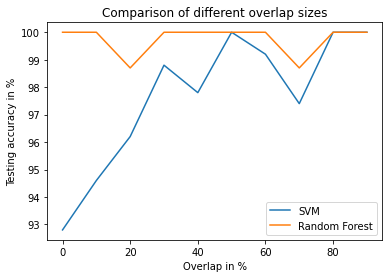

In [18]:
import matplotlib.pyplot as plt

overlaps = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
results_rf = [100, 100, 98.7, 100, 100, 100, 100, 98.7, 100, 100]
results_svm = [92.8, 94.6, 96.2, 98.8, 97.8, 100, 99.2, 97.4, 100, 100]

plt.plot(overlaps, results_svm, label='SVM')
plt.plot(overlaps, results_rf, label='Random Forest')
plt.xlabel("Overlap in %")
plt.ylabel("Testing accuracy in %")
plt.title("Comparison of different overlap sizes")
plt.legend()
plt.show()

## Choosing binning size

45 bins per axis are chosen, because it has the best training (k-cross validation) accuracy of the ones with a 100% testing accuracy for both models

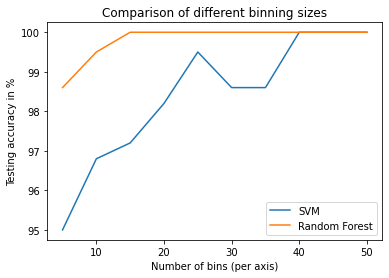

In [19]:
import matplotlib.pyplot as plt

binning_size = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results_rf = [98.6, 99.5, 100, 100, 100, 100, 100, 100, 100, 100]
results_svm = [95.0, 96.8, 97.2, 98.2, 99.5, 98.6, 98.6, 100, 100, 100]

plt.plot(binning_size, results_svm, label='SVM')
plt.plot(binning_size, results_rf, label='Random Forest')
plt.xlabel("Number of bins (per axis)")
plt.ylabel("Testing accuracy in %")
plt.title("Comparison of different binning sizes")
plt.legend()
plt.show()

# Data visualization (binned spectrograms)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
cmap=plt.cm.bone
cmap.set_under(color='k', alpha=None)

C:\Users\Timmy\AppData\Local\Temp\ipykernel_15620\3670946234.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under(color='k', alpha=None)


## Walking

### Accelerometer x

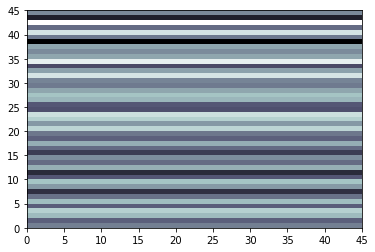

In [21]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][0][2]),cmap=cmap)

### Accelerometer y

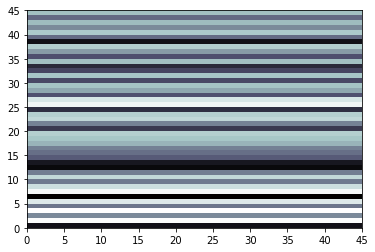

In [22]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][1][2]),cmap=cmap)

### Accelerometer z

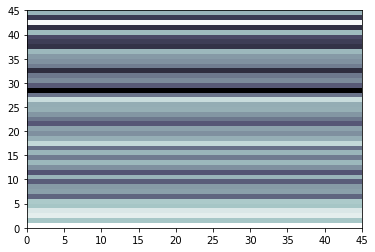

In [23]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][2][2]),cmap=cmap)

### Gyroscope x

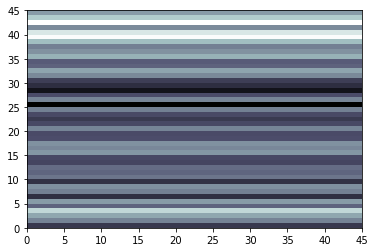

In [24]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][3][2]),cmap=cmap)

### Gyroscope y

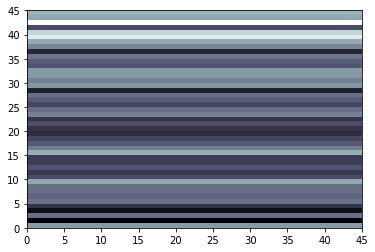

In [25]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][4][2]),cmap=cmap)

### Gyroscope z

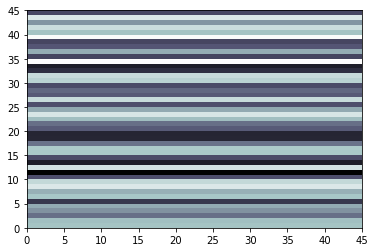

In [26]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][5][2]),cmap=cmap)

## Rowing

### Accelerometer x

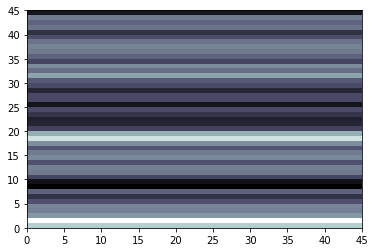

In [27]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][0][2]),cmap=cmap)

### Accelerometer y

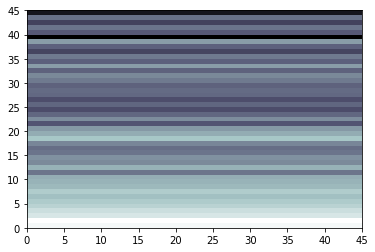

In [28]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][1][2]),cmap=cmap)

### Accelerometer z

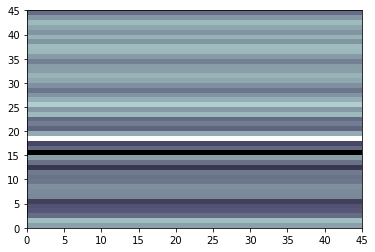

In [29]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][2][2]),cmap=cmap)

### Gyroscope x

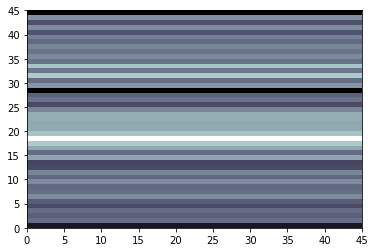

In [30]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][3][2]),cmap=cmap)

### Gyroscope y

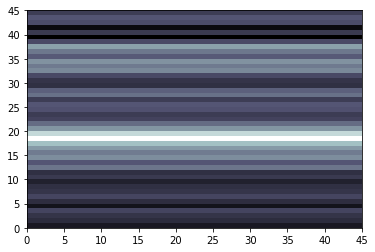

In [31]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][4][2]),cmap=cmap)

### Gyroscope z

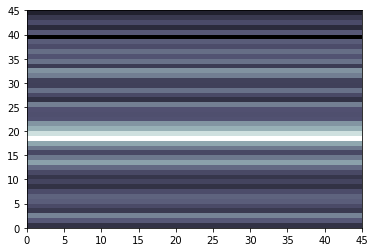

In [32]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][5][2]),cmap=cmap)

## Climbing down

### Accelerometer x

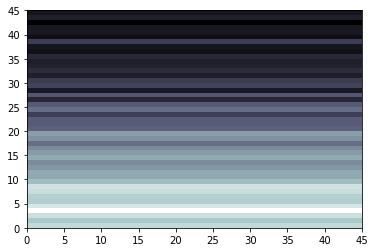

In [33]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][0][2]),cmap=cmap)

### Accelerometer y

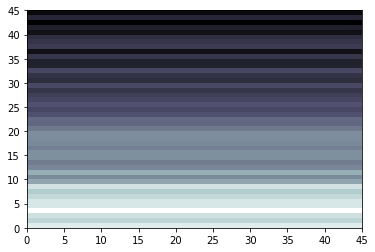

In [34]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][1][2]),cmap=cmap)

### Accelerometer z

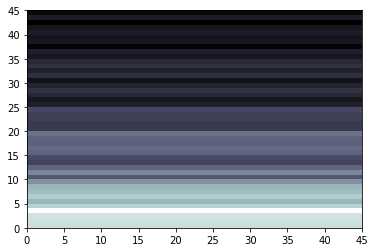

In [35]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][2][2]),cmap=cmap)

### Gyroscope x

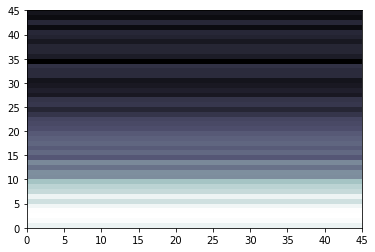

In [36]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][3][2]),cmap=cmap)

### Gyroscope y

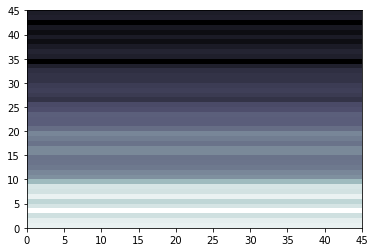

In [37]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][4][2]),cmap=cmap)

### Gyroscope z

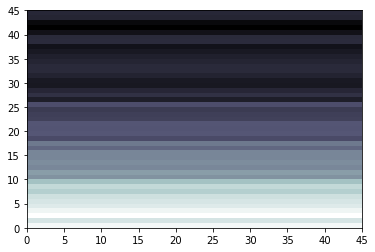

In [38]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][5][2]),cmap=cmap)

## Climbing up

### Accelerometer x

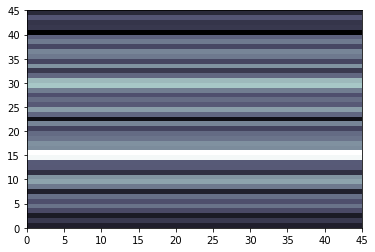

In [39]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][0][2]),cmap=cmap)

### Accelerometer y

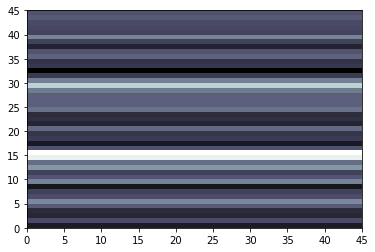

In [40]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][1][2]),cmap=cmap)

### Accelerometer z

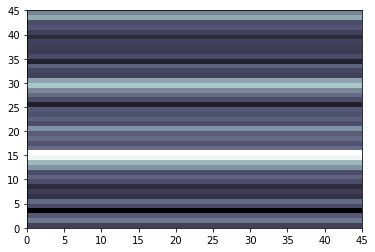

In [41]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][2][2]),cmap=cmap)

### Gyroscope x

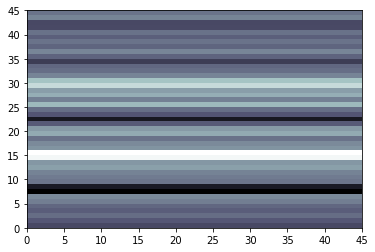

In [42]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][3][2]),cmap=cmap)

### Gyroscope y

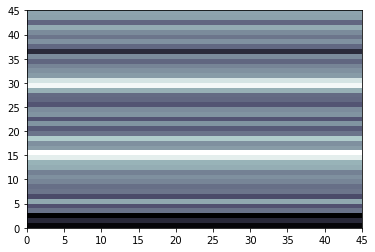

In [43]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][4][2]),cmap=cmap)

### Gyroscope z

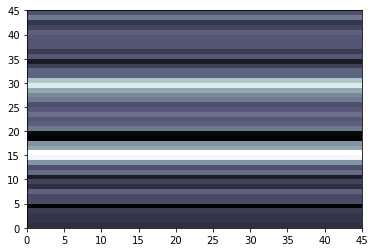

In [44]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][5][2]),cmap=cmap)

## Standing

### Accelerometer x

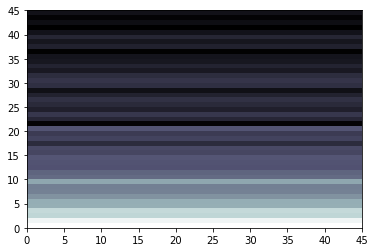

In [45]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][0][2]),cmap=cmap)

### Accelerometer y

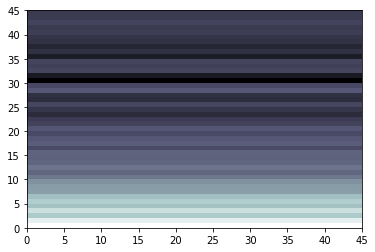

In [46]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][1][2]),cmap=cmap)

### Accelerometer z

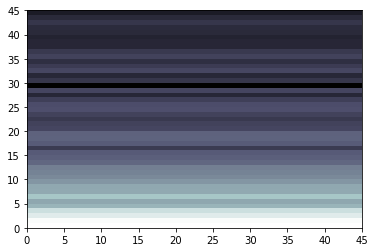

In [47]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][2][2]),cmap=cmap)

### Gyroscope x

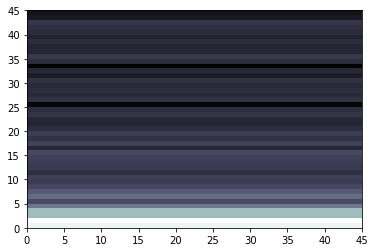

In [48]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][3][2]),cmap=cmap)

### Gyroscope y

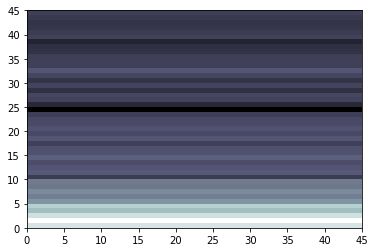

In [49]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][4][2]),cmap=cmap)

### Gyroscope z

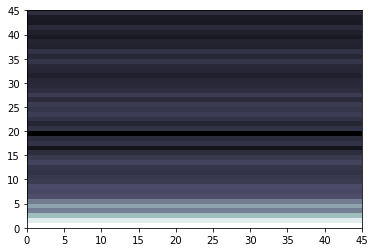

In [50]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][5][2]),cmap=cmap)